<div align='center'>
    <h1>Capuchin Bird Calls Prediction</h1>
</div>
<br />
<div align='center'>
    <a href='https://sabbir-ahmed16.github.io/portfolio/'>Portfolio</a> | <a href='https://www.linkedin.com/in/sabbir-ahmed-cuet-ete/'>LinkedIn</a> | <a href='https://www.facebook.com/SabbirAhmed823'>Facebook</a>
</div>

### Loading Required Dependencies

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')

### Defining Data Loading Function

In [2]:
# Defining path for a single capuchinbird call file and a not capuchinbird call file
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(filename):
    # Loading wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channel)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Remove trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Downsampling the audio
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [4]:
# Loading the capuchin and not capuchin bird call file
capuchin_wave = load_wav_16k_mono(CAPUCHIN_FILE)
not_capuchin_wave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [5]:
# Listen to a capuchin bird call
Audio(capuchin_wave, rate=16000)

In [6]:
# Listen to a not capuchin clip
Audio(not_capuchin_wave, rate=16000)

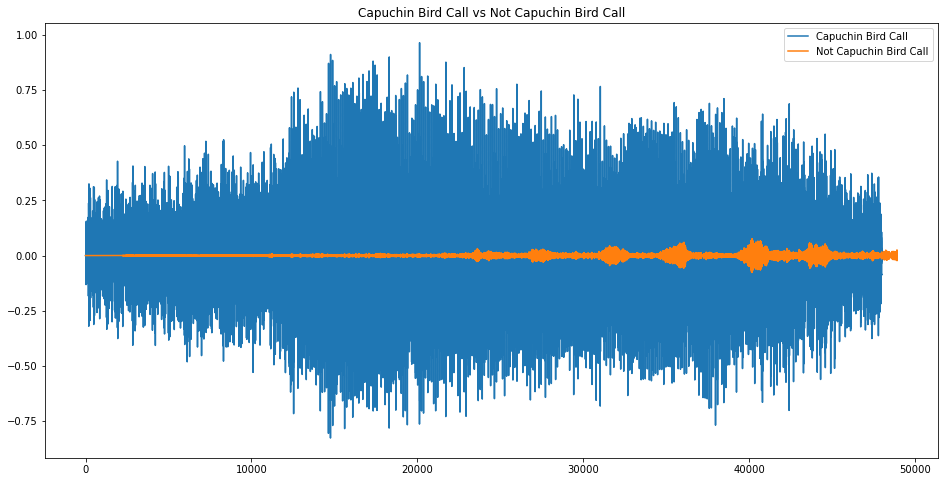

In [7]:
# Plotting the wave
plt.figure(figsize=(16, 8))
plt.plot(capuchin_wave, label='Capuchin Bird Call')
plt.plot(not_capuchin_wave, label='Not Capuchin Bird Call')
plt.title('Capuchin Bird Call vs Not Capuchin Bird Call')
plt.legend(loc="upper right")
plt.show()

### Create Tensorflow Dataset

In [8]:
# Defining paths to positive and negative data
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [9]:
# Creating dataset
pos = tf.data.Dataset.list_files(POS + '\*.wav')
neg = tf.data.Dataset.list_files(NEG + '\*.wav')

In [10]:
# Adding labels and combining positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [11]:
# positives.as_numpy_iterator().next()

In [12]:
# negatives.as_numpy_iterator().next()

### Exploratory Data Analysis

In [13]:
# Getting the lengths of all capuchinbird clips
lengths = []

for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

### Calculating mean, min and max 

In [14]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [15]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

<div class='alert alert-block alert-info'>
The average clip length of capuchin bird call can be calculated using the formula, clip length =
$
    \frac{\text{length of sample}}{\text{sampling rate}}
$
<ul>
<li>Average clip length = $54156 / 16000 = 3.38475s$</li>
<li>Minimum clip length = $32000 / 16000 = 2s$</li>
<li>Maximum clip length = $80000 / 16000 = 5s$</li><br />
</ul>
    <b>In this case, we'll take 3s clip of capuchin bird call to reduce computation.</b>
</div>

### Preprocessing

In [17]:
def preprocess(filepath, label):
    wav = load_wav_16k_mono(filepath)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

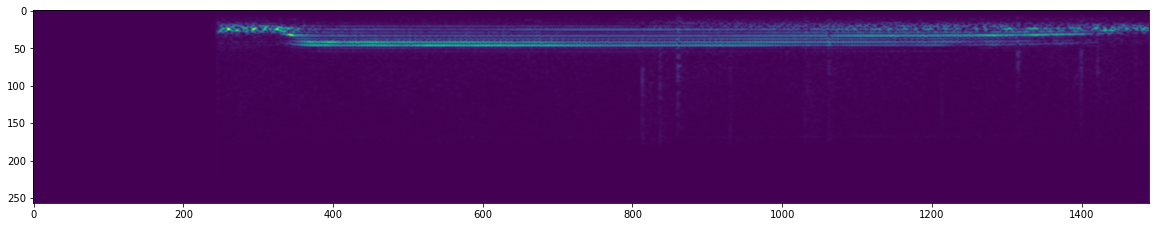

In [20]:
plt.figure(figsize=(20, 12))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [21]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [22]:
spectrogram, label = preprocess(filepath, label)

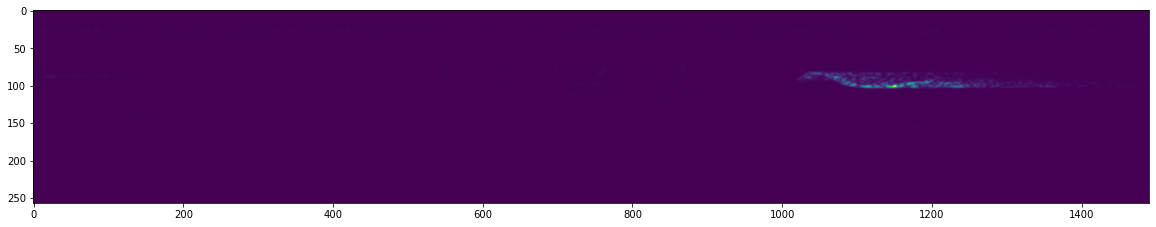

In [23]:
plt.figure(figsize=(20, 12))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Creating a Tensorflow Data Pipeline

In [24]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [25]:
# Printing the length of datasets
print(f'Length of dataset is: {len(data)}')

Length of dataset is: 51


In [26]:
# Splitting the data into train and test set
train = data.take(36)
test = data.skip(36).take(15)

In [27]:
samples, labels = train.as_numpy_iterator().next()

In [28]:
samples.shape

(16, 1491, 257, 1)

### Building and Training a Convolutional Neural Network

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

In [30]:
inputs = keras.Input(shape=(1491, 257, 1))
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [31]:
model = keras.Model(inputs=inputs, outputs=outputs, name='CapNet_Model')

In [32]:
model.summary()

Model: "CapNet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1491, 257, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 1491, 257, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 745, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 745, 128, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 372, 64, 16)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 372, 64, 32)      

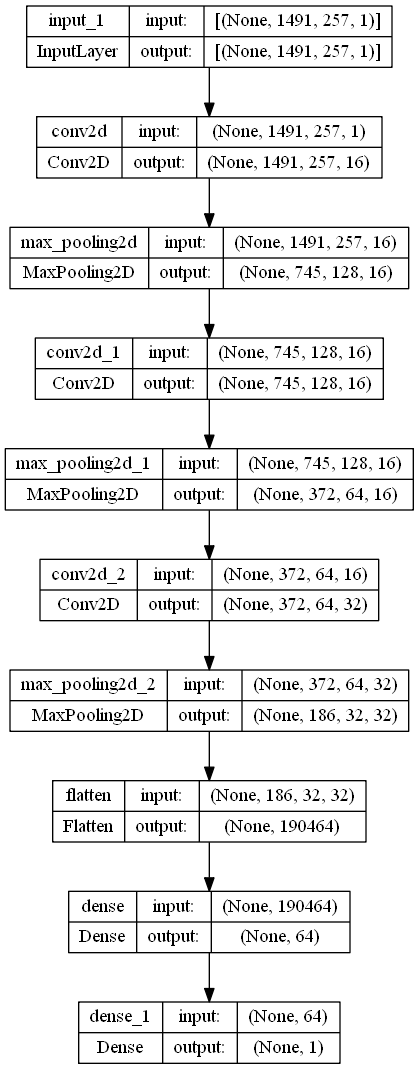

In [33]:
keras.utils.plot_model(model, "CapNet_info.png", show_shapes=True)

In [34]:
keras.backend.clear_session()

model.compile(
    loss=keras.losses.BinaryCrossentropy(), 
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
36/36 [==============================] - 73s 2s/step - loss: 0.3063 - accuracy: 0.9149 - val_loss: 0.1379 - val_accuracy: 0.9615
Epoch 2/10
36/36 [==============================] - 67s 2s/step - loss: 0.1506 - accuracy: 0.9514 - val_loss: 0.0239 - val_accuracy: 0.9957
Epoch 3/10
36/36 [==============================] - 68s 2s/step - loss: 0.0710 - accuracy: 0.9844 - val_loss: 0.0745 - val_accuracy: 0.9573
Epoch 4/10
36/36 [==============================] - 68s 2s/step - loss: 0.1058 - accuracy: 0.9566 - val_loss: 0.0319 - val_accuracy: 0.9915
Epoch 5/10
36/36 [==============================] - 73s 2s/step - loss: 0.0294 - accuracy: 0.9896 - val_loss: 0.0774 - val_accuracy: 0.9872
Epoch 6/10
36/36 [==============================] - 70s 2s/step - loss: 0.0793 - accuracy: 0.9844 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 7/10
36/36 [==============================] - 69s 2s/step - loss: 0.0264 - accuracy: 0.9948 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 8/10
36/36 [==

In [35]:
history_df = pd.DataFrame(history.history)

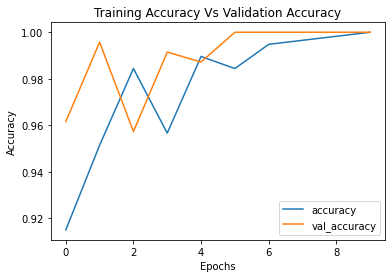

In [36]:
# Accuracy plot
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

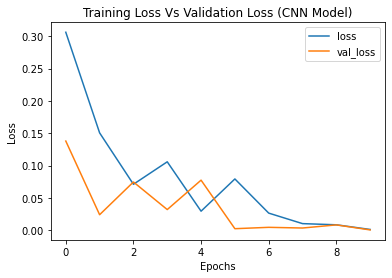

In [37]:
# Loss plot
history_df[['loss', 'val_loss']].plot()
plt.title('Training Loss Vs Validation Loss (CNN Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Making Prediction on Test Set

In [38]:
X_test, y_test = test.as_numpy_iterator().next()

In [39]:
y_predicted = model.predict(X_test)

1/1 [==============================] - 0s 460ms/step


In [40]:
# Converting to classes
y_predicted = [1 if prob > 0.99 else 0 for prob in y_predicted]

In [41]:
print(y_predicted)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]


In [42]:
# Printing the actual label
print(y_test)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.]


### Making Prediction on Forest Recording

In [43]:
# Function to load .mp3 file from forest recording
def load_mp3_16k_mono(filename):
    """Load a mp3 file, convert it to a tensor and downsample it to 16kHz single channel audio."""
    res = tfio.audio.AudioIOTensor(filename)
    # Converting into tensor and combining two channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Downsampling to 16kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    
    return wav

In [44]:
sample_record = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [45]:
wav = load_mp3_16k_mono(sample_record)

In [46]:
# Creating dataset of sliding windows using long forest recording
wav_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [47]:
sample, index = wav_slices.as_numpy_iterator().next()

In [48]:
sample.shape

(1, 48000)

In [49]:
# Function to convert clips to spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [50]:
# Building a pipeline
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [51]:
y_predicted = model.predict(audio_slices)
y_predicted = [1 if prob > 0.99 else 0 for prob in y_predicted]

1/1 [==============================] - 2s 2s/step


In [52]:
print(y_predicted)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<div class='alert alert-block alert-danger' align='center'>
<b>As the capuchin bird calls are longer than 3s, the model predicted a single call as two consecutive calls which needs to be grouped together.</b>
</div>

In [53]:
# Grouping consecutive detections
from itertools import groupby

In [54]:
y_predicted = [key for key, group in groupby(y_predicted)]
calls = tf.math.reduce_sum(y_predicted).numpy()

In [55]:
print(y_predicted)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [56]:
print("Number of capuchin bird calls in the clip is: ", calls)

Number of capuchin bird calls in the clip is:  5


In [57]:
# Listen to the loaded forest recording to check if the number of calls are same as predicted by the model
Audio(wav, rate=16000)

<div class='alert alert-block alert-success' align='center'>
    <b>If you hear 5 capuchin bird calls in the recording then congrats!</b>
</div>

In [58]:
# Looping over all forest recordings
results = {}

for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    path = os.path.join('data', 'Forest Recordings', file)
    
    wav =  load_mp3_16k_mono(path)
    wav_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    wav_slices = wav_slices.map(preprocess_mp3)
    wav_slices = wav_slices.batch(64)
    
    y_predicted = model.predict(wav_slices)
    
    results[file] = y_predicted

1/1 [==============================] - 2s 2s/step


In [59]:
# Converting predictions into classes
predicted_classes = {}

for file, logits in results.items():
    predicted_classes[file] = [1 if prob > 0.99 else 0 for prob in logits]

In [60]:
# print(predicted_classes)

In [61]:
# Grouping consecutive detections
final_output = {}

for file, preds in predicted_classes.items():
    final_output[file] = tf.math.reduce_sum([key for key, group in groupby(preds)]).numpy()

In [62]:
for filename, call_count in final_output.items():
    print(f'{filename}: {call_count}')

recording_00.mp3: 5
recording_01.mp3: 0
recording_02.mp3: 0
recording_03.mp3: 0
recording_04.mp3: 4
recording_05.mp3: 0
recording_06.mp3: 5
recording_07.mp3: 2
recording_08.mp3: 25
recording_09.mp3: 0
recording_10.mp3: 5
recording_11.mp3: 3
recording_12.mp3: 2
recording_13.mp3: 0
recording_14.mp3: 0
recording_15.mp3: 2
recording_16.mp3: 5
recording_17.mp3: 10
recording_18.mp3: 6
recording_19.mp3: 1
recording_20.mp3: 0
recording_21.mp3: 1
recording_22.mp3: 2
recording_23.mp3: 5
recording_24.mp3: 0
recording_25.mp3: 16
recording_26.mp3: 2
recording_27.mp3: 0
recording_28.mp3: 16
recording_29.mp3: 1
recording_30.mp3: 3
recording_31.mp3: 1
recording_32.mp3: 2
recording_33.mp3: 0
recording_34.mp3: 4
recording_35.mp3: 0
recording_36.mp3: 2
recording_37.mp3: 3
recording_38.mp3: 9
recording_39.mp3: 9
recording_40.mp3: 1
recording_41.mp3: 0
recording_42.mp3: 0
recording_43.mp3: 5
recording_44.mp3: 1
recording_45.mp3: 3
recording_46.mp3: 13
recording_47.mp3: 17
recording_48.mp3: 4
recording_49.m

In [63]:
# Exporting the result to a csv file
import csv

In [64]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'no_of_capuchin_calls'])
    
    for key, value in final_output.items():
        writer.writerow([key, value])